In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy

import sklearn
from sklearn.mixture import GaussianMixture

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import sys
sys.path.append('../')
import adaprobe

In [3]:
import jax
import jax.numpy as jnp

In [4]:
fontsize=13

In [5]:
os.listdir('data')
fname = '201118_cell1_A'

In [6]:
data = np.load('data/one_cell_per_plane_plus_10_random_%s.npz'%fname)

In [8]:
y = data['y']
stimulus_matrix = data['stimulus_matrix']
y_psc = data['y_psc']
N, K = stimulus_matrix.shape
trial_length = y_psc.shape[1]
n_repeats = K//N

In [ ]:
ispectra = np.array([np.max(scipy.signal.correlate(y_psc[i], y_psc[i])) for i in range(K)])

In [10]:
# configure priors
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
beta_prior = 3e0 * np.ones(N)
mu_prior = np.zeros(N)

priors = {
    'alpha': np.ones(N),
    'beta': beta_prior,
    'mu': mu_prior,
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

fit_options = {
    'penalty': 5e-2,
    'iters': 100,
    'num_mc_samples': 20,
    'seed': 0,
    'learn_alpha': False
#     'lam_mask': 
}

model = adaprobe.Model(np.zeros(N), priors=priors)

In [11]:
model.reset()
model.fit(y, stimulus_matrix, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

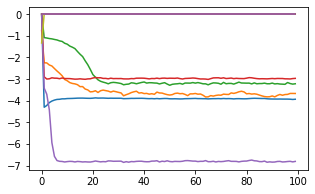

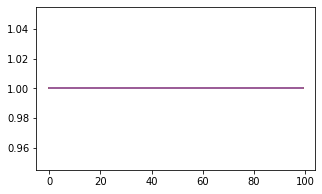

In [12]:
plt.figure(figsize=(5, 3))
plt.plot(model.history['mu'])
# plt.legend(range(N))
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(model.history['alpha'])
plt.show()

In [13]:
lam = np.array(model.state['lam']).T
# alpha = np.array(model.state['alpha'])
alpha = np.array(model.state['mu'] != 0).astype(float)

phi = model.state['phi']
phi_cov = model.state['phi_cov']
phi_sdevs = np.sqrt(np.array([np.diag(phi_cov[n]) for n in range(N)]))
plow = phi - phi_sdevs
phigh = phi + phi_sdevs

Irng = np.arange(0, 91)

xrange = np.arange(-21, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
postmax = np.max(post)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

<ipython-input-14-5aeada958062>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])


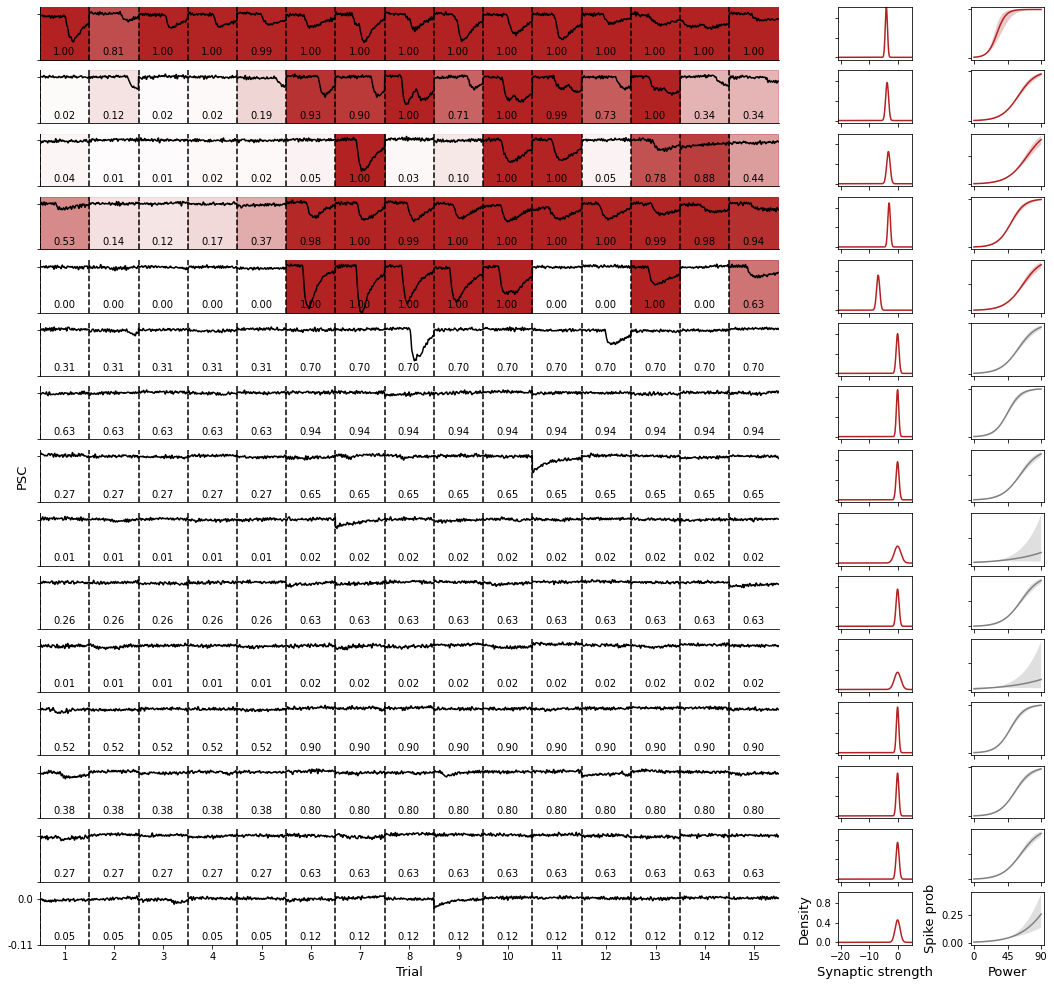

In [14]:
trial_breaks = np.arange(0, trial_length * n_repeats + 1, trial_length)

plt.figure(figsize=(18, 1.15 * N))
gs = gridspec.GridSpec(N, 3, width_ratios=[15, 1.5, 1.5])
    
for n in range(N):
    # Spike predictions
    plt.subplot(gs[n, 0])
    stim_locs = np.where(stimulus_matrix[n] > 0)[0]
    this_y_psc = y_psc[stim_locs].flatten()/np.max(np.abs(y_psc))
    fill_lower = -1
    fill_upper = 0.15
    plt.xlim([0, trial_length*n_repeats])
    plt.ylim([-1, 0.15])
    for tb in range(len(trial_breaks) - 1):
        plt.plot([trial_breaks[tb], trial_breaks[tb]], [-1, 0.15], '--', color='k')
        plt.fill_between(np.arange(trial_length * tb, trial_length * (tb + 1)), fill_lower * np.ones(trial_length), fill_upper * np.ones(trial_length), color='firebrick', alpha=lam[n, stim_locs][tb] * alpha[n])
        plt.text(trial_breaks[tb] + trial_length/2 - 70, -0.9, '%.2f'%lam[n, stim_locs][tb])
    plt.plot(this_y_psc, color='k')
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    
    if n == N-1:
        plt.xticks(trial_breaks[:-1] + trial_length/2)
        plt.gca().set_xticklabels(np.arange(1, n_repeats+1))
        plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])
        plt.xlabel('Trial', fontsize=fontsize)
    elif n == N//2:
        plt.ylabel('PSC', fontsize=fontsize)
        plt.xticks([])
        plt.gca().set_yticklabels([])
    else:
        plt.xticks([])
        plt.gca().set_yticklabels([])
        
    # Synapses
    plt.subplot(gs[n, 1])
    plt.plot(xrange, post[n], color='firebrick')
    plt.xlim(np.min(xrange), np.max(xrange))
    plt.ylim([-0.05, postmax])
    if n < N-1:
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
    else:
        plt.xlabel('Synaptic strength', fontsize=fontsize)
        plt.ylabel('Density', fontsize=fontsize)
    plt.xticks(np.arange(-20, 1, 10))
    plt.yticks([0, 0.4, 0.8])
    
    # Spike-power relationship
    plt.subplot(gs[n, 2])
    if alpha[n] < 0.5:
        sigcol = 'gray'
    else:
        sigcol = 'firebrick'
    plt.plot(sigmoid(phi[n, 0] * Irng - phi[n, 1]), color=sigcol)
    plt.fill_between(Irng, sigmoid(plow[n, 0] * Irng - plow[n, 1]), sigmoid(phigh[n, 0] * Irng - phigh[n, 1]), facecolor=sigcol, edgecolor='None', alpha=0.25)
    if n == N-1:
        plt.xlabel('Power', fontsize=fontsize)
        plt.ylabel('Spike prob', fontsize=fontsize)
    else:
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
    plt.xticks([0, 45, 90])
    
# plt.savefig('figs/one_cell_per_plane_plus_10_random_trunc_to_N%i_%s.png'%(N, fname), format='png', bbox_inches='tight', dpi=200, facecolor='white')
plt.show()

In [15]:
model.state['mu']

DeviceArray([-3.93230154, -3.66647242, -3.21757544, -2.96846547,
             -6.80483455, -0.        ,  0.        , -0.        ,
             -0.        ,  0.        , -0.        ,  0.        ,
              0.        ,  0.        ,  0.        ], dtype=float64)

# Simulating multi-spot stimulation

In [ ]:
powers = np.unique(stimulus_matrix[stimulus_matrix > 0])
R = 2
Kmulti = int(np.ceil(K/R))
Kmulti = K
trial_len = y_psc.shape[1]

In [ ]:
y_psc_multi = np.zeros((Kmulti, trial_len))
stimulus_matrix_multi = np.zeros((N, Kmulti))

for k in range(Kmulti):
    tars = np.random.choice(N, R, replace=False)
    power = np.random.choice(powers)
    sampled_trials = [np.random.choice(np.where(stimulus_matrix[tar] == power)[0]) for tar in tars]
    y_psc_multi[k] = np.sum(y_psc[sampled_trials], 0)
    stimulus_matrix_multi[tars, k] = power

y_multi = np.trapz(y_psc_multi, axis=1)

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(stimulus_matrix_multi, aspect='auto', interpolation='nearest')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 1))
plt.plot(np.trapz(y_psc_multi, axis=1))
plt.xlim([0, Kmulti])
plt.axis('off')
plt.show()

In [ ]:
# configure priors
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
beta_prior = 3e0 * np.ones(N)
mu_prior = np.zeros(N)

priors = {
    'alpha': np.ones(N),
    'beta': beta_prior,
    'mu': mu_prior,
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

fit_options = {
    'penalty': 1e-1,
    'iters': 100,
    'num_mc_samples': 50,
    'seed': 0,
    'learn_alpha': False
#     'lam_mask': 
}

model_ms = adaprobe.Model(np.zeros(N), priors=priors)

In [ ]:
model_ms.reset()
%time model_ms.fit(y_multi, stimulus_matrix_multi, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

In [25]:
Irng = np.arange(0, 91)
xrange = np.arange(-16, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [26]:
def plot_inferred_spikes_multi(y_psc, stimulus_matrix, model):
    lam = np.array(model.state['lam']).T
#     alpha = np.array(model.state['alpha'])
    alpha = np.array((model.state['mu'] != 0).astype(float))
    
    phi = model.state['phi']
    phi_cov = model.state['phi_cov']
    phi_sdevs = np.sqrt(np.array([np.diag(phi_cov[n]) for n in range(N)]))
    plow = phi - phi_sdevs
    phigh = phi + phi_sdevs

    post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
    postmax = np.max(post)

    max_trial_breaks = 30
    trial_breaks = np.arange(0, trial_length * max_trial_breaks + 1, trial_length)

    plt.figure(figsize=(25, 1.15 * N))
    gs = gridspec.GridSpec(N, 2, width_ratios=[15, 1.5])

    for n in range(N):
        # Spike predictions
        plt.subplot(gs[n, 0])
        stim_locs = np.where(stimulus_matrix[n] > 0)[0]
        this_y_psc = y_psc[stim_locs].flatten()/np.max(np.abs(y_psc))
        fill_lower = -1
        fill_upper = 0.15
        plt.ylim([-1, 0.15])
        tbmax = np.min([len(trial_breaks) - 1, len(stim_locs)])
        plt.xlim([0, trial_length*tbmax])
        for tb in range(tbmax):
            plt.plot([trial_breaks[tb], trial_breaks[tb]], [-1, 0.15], '--', color='k')
            plt.fill_between(np.arange(trial_length * tb, trial_length * (tb + 1)), fill_lower * np.ones(trial_length), fill_upper * np.ones(trial_length), color='firebrick', alpha=lam[n, stim_locs][tb] * alpha[n])
            plt.text(trial_breaks[tb] + trial_length/2 - 70, -0.9, '%.2f'%(lam[n, stim_locs][tb]))
        plt.plot(this_y_psc[:tbmax*trial_len], color='k')
        for loc in ['top', 'right']:
            plt.gca().spines[loc].set_visible(False)

        if n == N-1:
#             plt.xticks(trial_breaks[:-1] + trial_length/2)
#             plt.gca().set_xticklabels(np.arange(1, tbmax+1))
            plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])
            plt.xlabel('Trial', fontsize=fontsize)
        elif n == N//2:
            plt.ylabel('PSC', fontsize=fontsize)
            plt.xticks([])
            plt.gca().set_yticklabels([])
        else:
            plt.xticks([])
            plt.gca().set_yticklabels([])

        # Synapses
        plt.subplot(gs[n, 1])
        plt.plot(xrange, post[n], color='firebrick')
        plt.xlim(np.min(xrange), np.max(xrange))
        plt.ylim([-0.05, postmax])
        if n < N-1:
            plt.gca().set_xticklabels([])
            plt.gca().set_yticklabels([])
        else:
            plt.xlabel('Synaptic strength', fontsize=fontsize)
            plt.ylabel('Density', fontsize=fontsize)
#         plt.xticks(np.arange(-20, 1, 10))
#         plt.yticks([0, 0.4, 0.8])
        
    plt.show()


In [ ]:
model_ms.state['mu']

In [ ]:
plot_inferred_spikes_multi(y_psc_multi, stimulus_matrix_multi, model_ms)

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot([-6, 1], [-6, 1], '--', color='gray')
plt.scatter(model.state['mu'], model_ms.state['mu'], edgecolor='C1', facecolor='None', linewidth=3)
plt.xlim([-6, 2])
plt.ylim([-6, 2])
plt.xticks(np.arange(-6, 2, 2))
plt.yticks(np.arange(-6, 2, 2))
plt.ylabel('Inferred multi-spot mapping', fontsize=fontsize)
plt.xlabel('Inferred single-spot mapping', fontsize=fontsize)
plt.grid(linestyle='dashed')
plt.show()

In [ ]:
np.corrcoef(model.state['mu'], model_ms.state['mu'])

# Simulate multiple multispot expts for comparison

In [16]:
powers = np.unique(stimulus_matrix[stimulus_matrix > 0])
R = 2
Kmulti = [K//4, K//2, K]
nks = len(Kmulti)
trial_len = y_psc.shape[1]
y_psc_multi = [None for _ in range(nks)]
stimulus_matrix_multi = [None for _ in range(nks)]
y_multi = [None for _ in range(nks)]

In [17]:
for kindx, this_K in enumerate(Kmulti):
    y_psc_multi[kindx] = np.zeros((this_K, trial_len))
    stimulus_matrix_multi[kindx] = np.zeros((N, this_K))

    for k in range(this_K):
        tars = np.random.choice(N, R, replace=False)
        power = np.random.choice(powers)
        sampled_trials = [np.random.choice(np.where(stimulus_matrix[tar] == power)[0]) for tar in tars]
        y_psc_multi[kindx][k] = np.sum(y_psc[sampled_trials], 0)
        stimulus_matrix_multi[kindx][tars, k] = power

    y_multi[kindx] = np.trapz(y_psc_multi[kindx], axis=1)

In [18]:
# # configure priors
# phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
# phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
# beta_prior = 3e0 * np.ones(N)
# mu_prior = np.zeros(N)

# priors = {
#     'alpha': np.ones(N),
#     'beta': beta_prior,
#     'mu': mu_prior,
#     'phi': phi_prior,
#     'phi_cov': phi_cov_prior
# }

# fit_options = {
#     'penalty': 5e-2,
#     'iters': 100,
#     'num_mc_samples': 50,
#     'seed': 1,
#     'learn_alpha': False
# #     'lam_mask': 
# }

models = [adaprobe.Model(np.zeros(N), priors=priors) for _ in range(nks)]

In [19]:
for kindx in range(nks):
    %time models[kindx].fit(y_multi[kindx], stimulus_matrix_multi[kindx], fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

CPU times: user 12.1 s, sys: 469 ms, total: 12.5 s
Wall time: 6.13 s
CPU times: user 12.1 s, sys: 373 ms, total: 12.5 s
Wall time: 6.16 s
CPU times: user 9.07 s, sys: 402 ms, total: 9.48 s
Wall time: 4.88 s


<ipython-input-26-13b7ac4d7a19>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])


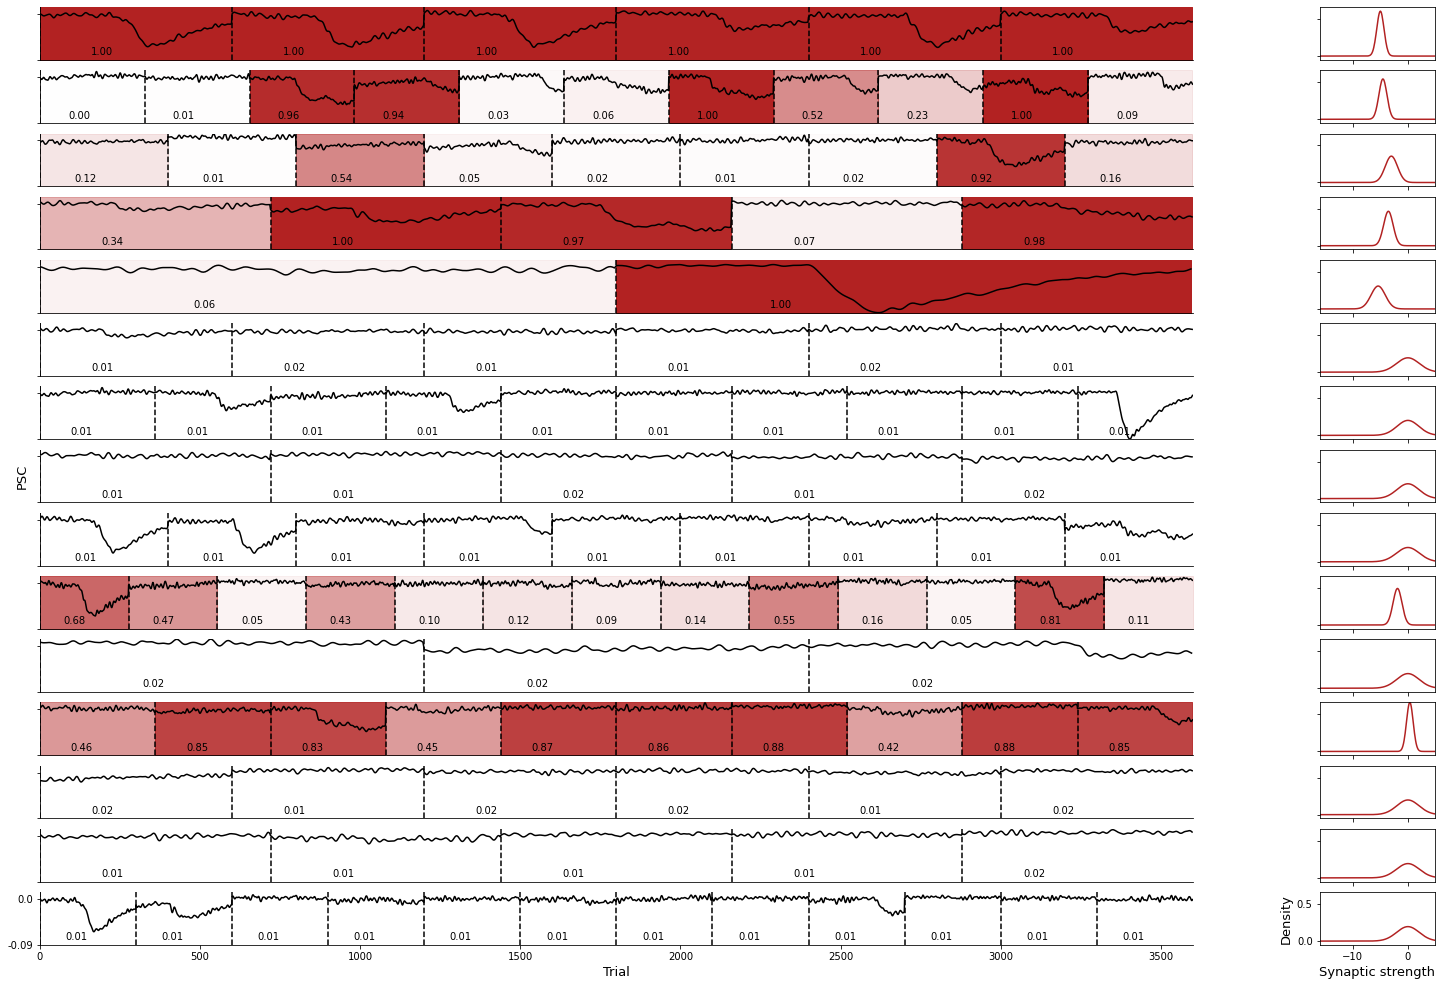

<ipython-input-26-13b7ac4d7a19>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])


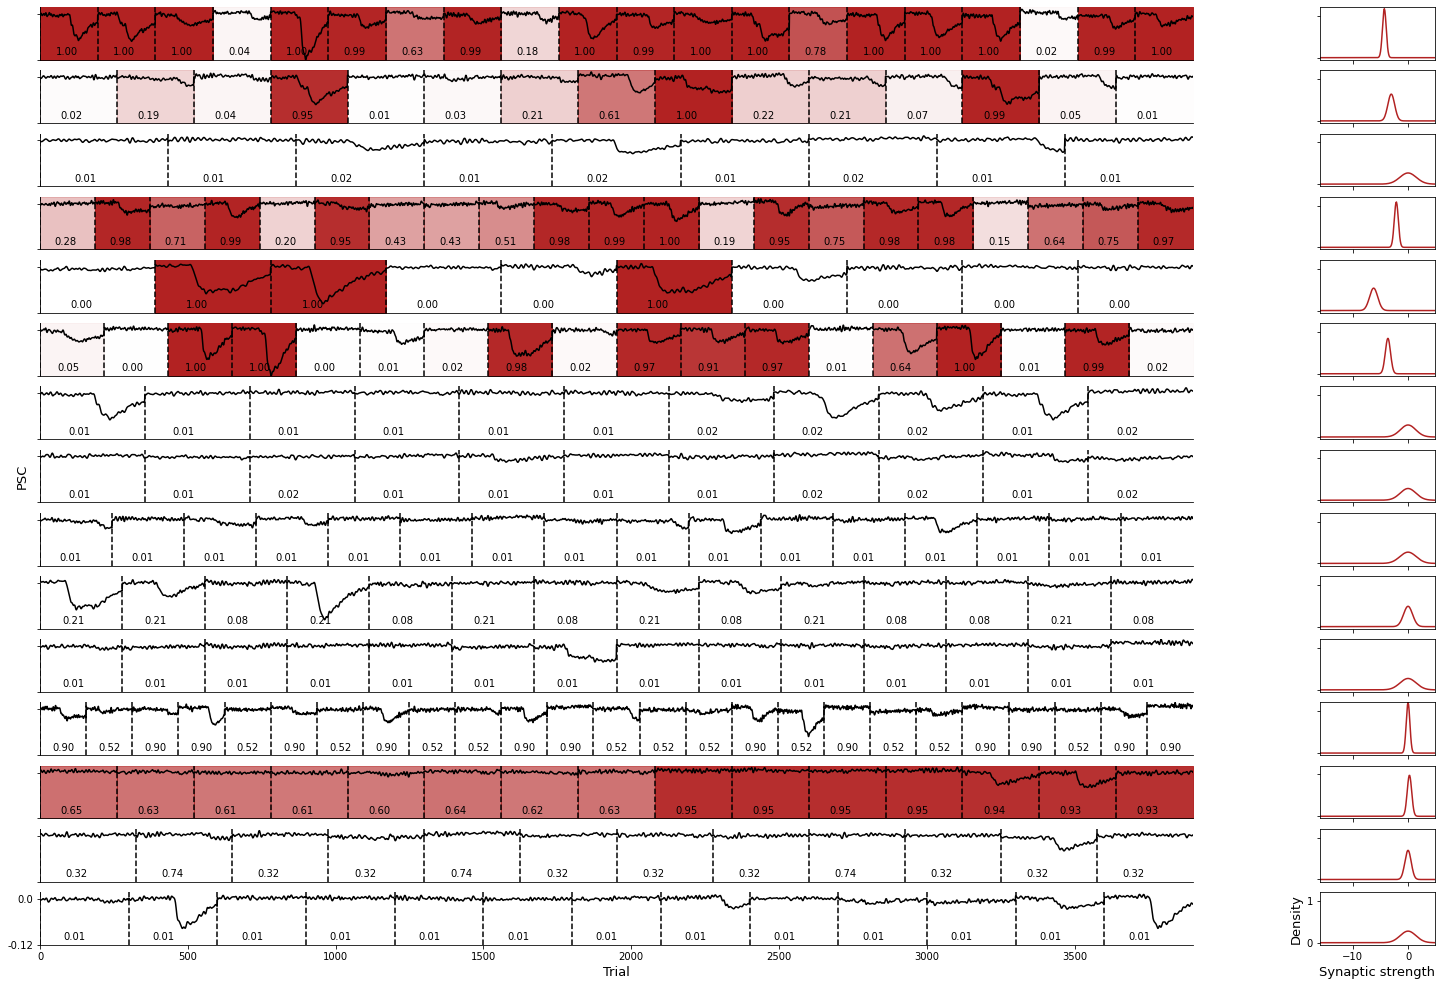

<ipython-input-26-13b7ac4d7a19>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])


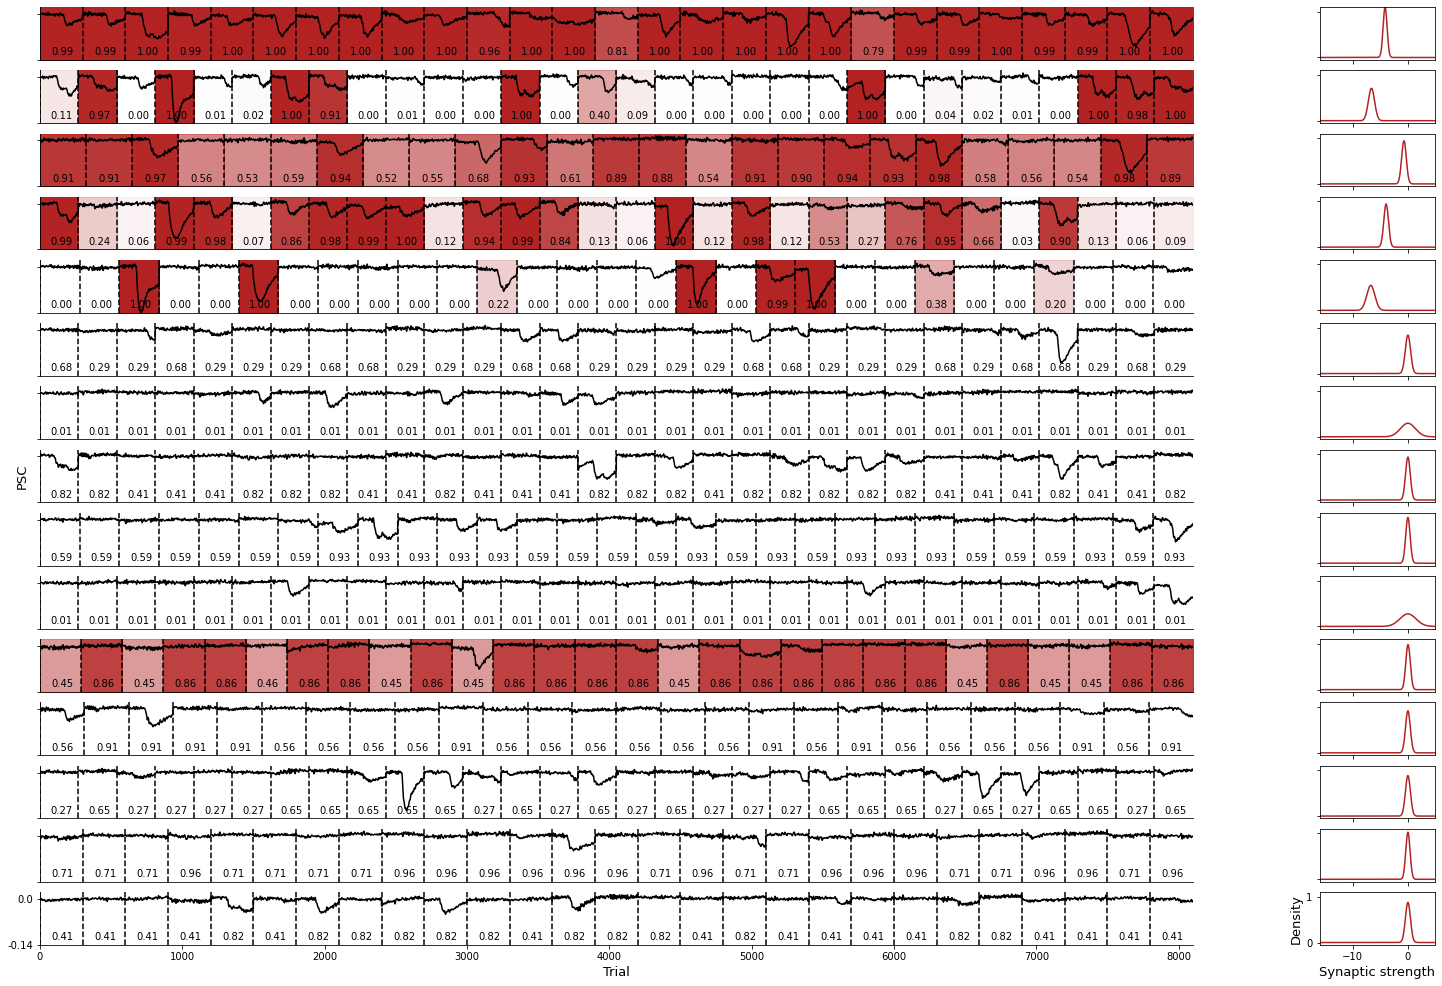

In [27]:
for kindx in range(nks):
    plot_inferred_spikes_multi(y_psc_multi[kindx], stimulus_matrix_multi[kindx], models[kindx])

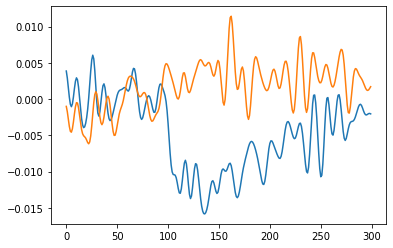

In [37]:
plt.plot(y_psc_multi[0][0])
plt.plot(y_psc_multi[0][1])

In [38]:
jnp.correlate(y_psc_multi[0][0], y_psc_multi[0][0])

DeviceArray([0.01479361], dtype=float64)

In [39]:
jnp.correlate(y_psc_multi[0][1], y_psc_multi[0][1])

DeviceArray([0.00394987], dtype=float64)

In [46]:
corrs = np.array([jnp.correlate(y_psc_multi[0][i], y_psc_multi[0][i]) for i in range(Kmulti[0])]).squeeze()

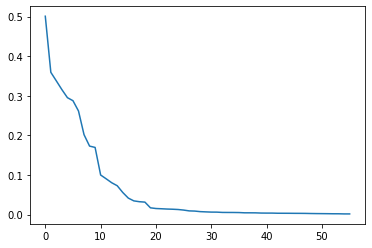

In [52]:
plt.plot(np.sort(corrs)[::-1])

In [55]:
corrs

array([0.01479361, 0.00394987, 0.00279967, 0.00383644, 0.00347137,
       0.3154656 , 0.35916897, 0.01541243, 0.16959846, 0.33741525,
       0.01362417, 0.29516859, 0.03261042, 0.08049096, 0.01148378,
       0.28753985, 0.00342905, 0.00755574, 0.07289791, 0.00179294,
       0.03468469, 0.00541274, 0.09039891, 0.2017951 , 0.00319667,
       0.00636683, 0.10000787, 0.00308193, 0.00522793, 0.00895748,
       0.00546647, 0.00339081, 0.0017843 , 0.00248643, 0.01716952,
       0.00628089, 0.00216388, 0.00455919, 0.00554678, 0.00382782,
       0.26152347, 0.00324645, 0.05587109, 0.00458121, 0.00446999,
       0.00261205, 0.01290331, 0.00941831, 0.01407697, 0.04169621,
       0.0021316 , 0.00235429, 0.17295578, 0.00693065, 0.50069332,
       0.03155983])

(array([37., 41., 43., 46., 46., 46., 48., 48., 49., 49., 50., 52., 53.,
        54., 55., 55., 55., 55., 55., 56.]),
 array([0.0017843 , 0.02672975, 0.05167521, 0.07662066, 0.10156611,
        0.12651156, 0.15145701, 0.17640246, 0.20134791, 0.22629336,
        0.25123881, 0.27618427, 0.30112972, 0.32607517, 0.35102062,
        0.37596607, 0.40091152, 0.42585697, 0.45080242, 0.47574787,
        0.50069332]),
 <BarContainer object of 20 artists>)

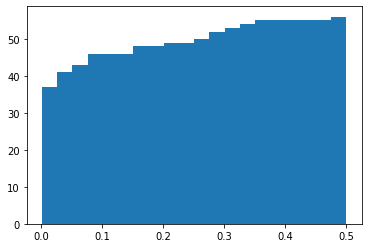

In [54]:
plt.hist(corrs, 20, cumulative=True)

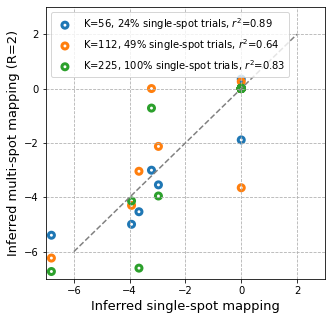

In [28]:
plt.figure(figsize=(5, 5))
plt.plot([-6, 2], [-6, 2], '--', color='gray')
for kindx in range(nks):
    plt.scatter(model.state['mu'], models[kindx].state['mu'], edgecolor='C%i'%kindx, facecolor='None', linewidth=3, \
                label='K=%i, %i%% single-spot trials, $r^2$=%.2f'%(Kmulti[kindx], 100*Kmulti[kindx]/K, \
                np.square(np.corrcoef(model.state['mu'], models[kindx].state['mu'])[0, 1])))
plt.xlim([-7, 3])
plt.ylim([-7, 3])
plt.xticks(np.arange(-6, 3, 2))
plt.yticks(np.arange(-6, 3, 2))
plt.ylabel('Inferred multi-spot mapping (R=%i)'%R, fontsize=fontsize)
plt.xlabel('Inferred single-spot mapping', fontsize=fontsize)
plt.grid(linestyle='dashed')
plt.legend(loc='upper left', frameon=True)
plt.show()

In [29]:
for kindx in range(nks):
    print(np.corrcoef(model.state['mu'], models[kindx].state['mu'])[0, 1])

0.9423656456794112
0.8018685245723597
0.9092243375221437
